# 🧪 [Part IV] Quantum Circuit Modeling and Custom Design

Welcome to the fourth notebook in Team Quail’s submission for the **FLIQ Hackathon**.

Having prepared our dataset and established classical baselines, we now turn to the core of our project: building and testing **quantum machine learning models** for DIA prediction.

In this notebook, we will:

- Design and implement our **own custom quantum circuit**
- Measure the models' performance

This marks the start of our quantum-first modeling phase, where we move beyond classical approaches and explore how quantum circuits can capture structure and signal in the descriptor space.


# Data Loading


In [ ]:
# install libraries if haven't
!pip install qiskit==1.4.2 torch qiskit-machine-learning pylatexenc

In [2]:
# import libraries
import torch
import torch.nn as nn
from torch.autograd import Function
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.utils import algorithm_globals

from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# show all columns
pd.set_option('display.max_columns', None)

In [3]:
# load training data
df_train = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
df_train.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,6.668,6.668,4.719,4.719,3.241,3.241,6.093,9.185,0.0,35.509,22.291,4.900,20.224,41.210,0.000,24.787,11.467,422.162,0.150,-4.28,31,403.272,1.218475e+07,20.012,7.859,3.564,175.833,14.164,0.452,14.164,0.413,0.018,0.413,-0.668,-0.452,2.443,113.689,422.424,4,10,0,0,0,1,3,4,9,2,11,0,6,0,0,0,158,16.204,17.199,23.107,0.0,0.000,6.093,4.900,28.819,5.099,0.000,18.199,18.199,18.808,19.041,4,13.922,34.450,0.000,24.732,0.000,6.545,30.525,53.976,0,11.518,16.367,26.508,0.0,0.000,44.983,11.282,5.817,5.563,42.595,0.0,22.552,0,138.07,0,0.000,0,0,0,0,0,0,15.727,62.940,0,0,0,2,0,5,0,0,0,0,1,1,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,3.545,4.661,2.449,3.735,1.520,2.621,12.073,10.002,0.0,0.000,5.063,14.963,0.000,18.261,30.332,0.000,5.734,236.062,0.182,-1.59,16,224.200,5.774616e+03,10.912,4.112,1.868,96.858,10.832,0.350,10.832,0.339,0.421,0.339,-0.843,-0.350,2.732,63.449,236.296,3,4,0,0,0,1,1,2,3,2,5,0,3,0,0,0,84,5.734,0.000,0.000,0.0,0.000,6.031,5.207,4.795,5.063,11.337,18.199,24.443,9.577,6.042,2,10.002,27.454,0.000,5.063,5.734,12.966,0.000,35.209,0,0.000,5.734,4.795,0.0,11.337,16.302,0.000,0.000,17.843,30.332,0.0,10.086,0,66.56,0,1.542,0,0,0,0,0,0,0.000,39.292,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.47

In [4]:
# load the rest
df_test = pd.read_csv("DIA_testset_RDKit_descriptors.csv")
df_scaled_train = pd.read_csv("DIA_trainingset_scaled.csv")
df_scaled_test = pd.read_csv("DIA_testset_scaled.csv")

In [5]:
# prepare the data as numpy
X_train = df_train.iloc[:, 2:].values.astype(np.float32)
X_train

array([[1.821000e+00, 1.266407e+03, 2.212100e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.363000e+00, 4.904340e+02, 1.170700e+01, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [3.551000e+00, 9.309200e+01, 6.784000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.766000e+00, 9.100310e+02, 2.112900e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.831000e+00, 9.261910e+02, 1.851800e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.617000e+00, 1.565385e+03, 3.054500e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [6]:
# prepare train data
y_train = df_train.iloc[:, 0].values.astype(np.float32).reshape(-1, 1)

In [7]:
# prepare X test data
X_test = df_test.iloc[:, 2:].values.astype(np.float32)
X_test

array([[1.484000e+00, 7.432070e+02, 2.146600e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.472000e+00, 8.689470e+02, 2.114000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.370000e-01, 1.409004e+03, 3.918900e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.670000e+00, 5.934880e+02, 1.536400e+01, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.603000e+00, 9.023710e+02, 2.242200e+01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [2.814000e+00, 1.098030e+02, 1.048500e+01, ..., 0.000000e+00,
        9.000000e+00, 0.000000e+00]], dtype=float32)

In [8]:
y_test = df_test.iloc[:, 0].values.astype(np.float32).reshape(-1, 1)
y_test

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],

In [9]:
# prepare the scaled values
X_train_scaled = df_scaled_train.values.astype(np.float32)
X_train_scaled

array([[-0.45287475,  1.3444654 ,  0.551264  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3103219 , -0.63225657, -0.8871936 , ...,  0.5       ,
         0.        ,  1.        ],
       [ 1.9831588 , -1.6444498 , -1.5671943 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.53032094,  0.43662933,  0.41424173, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43879366,  0.47779548,  0.05359136, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7401296 ,  2.106085  ,  1.7148483 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [10]:
X_test_scaled = df_scaled_test.values.astype(np.float32)
X_test_scaled

array([[-0.92740846,  0.01166007,  0.46079063, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94430584,  0.3319715 ,  0.4157611 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.8384569 ,  1.7077185 ,  2.9088206 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.6654997 , -0.36973572, -0.3820621 , ...,  0.5       ,
         0.        ,  0.        ],
       [ 0.64826876,  0.41711617,  0.5928403 , ...,  0.        ,
         0.05555556,  0.        ],
       [ 0.94538033, -1.6018801 , -1.0559852 , ...,  0.        ,
         0.5       ,  0.        ]], dtype=float32)

In [11]:
# doublecheck
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(477, 196)
(120, 196)
(477, 1)
(120, 1)
(477, 196)
(120, 196)


## Modelling
To explore the potential of quantum machine learning, we implemented a Variational Quantum Classifier (VQC) using the Qiskit Machine Learning framework. VQCs are a class of hybrid quantum-classical algorithms where classical data is encoded into quantum states, processed via parameterized quantum circuits (ansätze), and optimized using classical routines.

In our setup, we reduced the high-dimensional descriptor dataset using Principal Component Analysis (PCA) down to 2 to 6 components.

This was necessary to align with current quantum hardware and simulation limits, which are often constrained to a small number of qubits.

We constructed our quantum model as follows:

1. **Feature Map:** ZZFeatureMap with reps=1 to encode the 2D PCA features into quantum states using entangling ZZ interactions.

2. **Ansatz:** RealAmplitudes with reps=3, a parameterized circuit structure providing expressivity with a moderate number of trainable parameters.

3. **Optimizer:** COBYLA, a gradient-free method well-suited for noisy objective landscapes and hardware-in-the-loop training.

4. **Sampler:** We used StatevectorSampler as the backend simulator to evaluate the expectation values needed for optimization.

5. **Callback:** A callback_graph function tracked and visualized the loss (objective function value) over iterations for better interpretability.

In [16]:
# define callback graph
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### N = 2

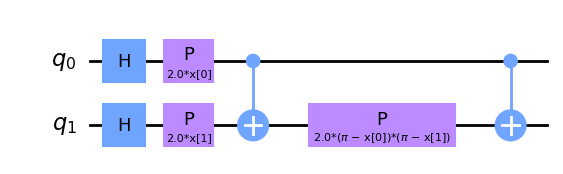

In [17]:
# we encode the 2D PCA features into quantum states using ZZ interaction
num_features = 2

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

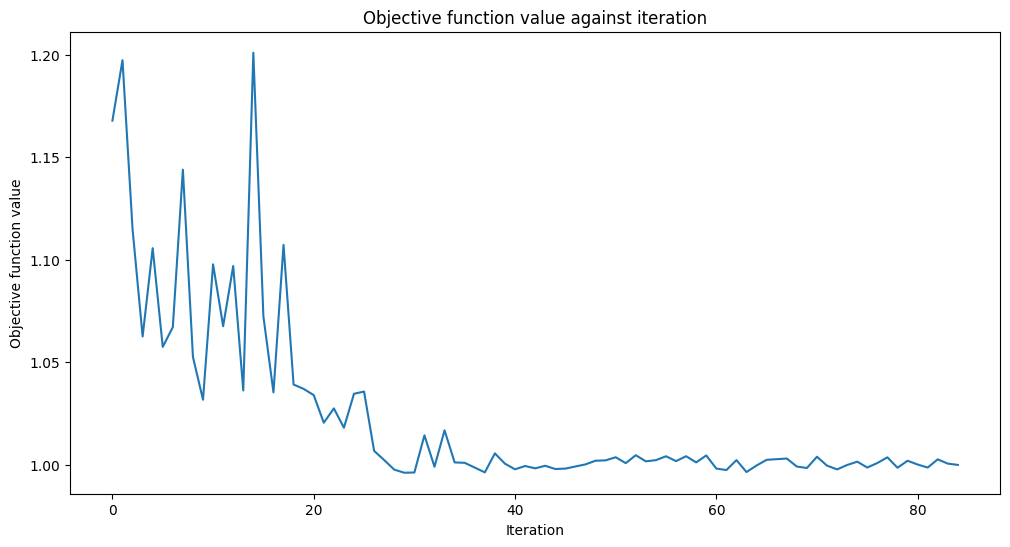

Training time: 396 seconds
Quantum VQC at N=2 on the training dataset: 0.53
Quantum VQC at N=2 on the test dataset:     0.57
N=2
              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69        66
         1.0       0.60      0.33      0.43        54

    accuracy                           0.60       120
   macro avg       0.60      0.58      0.56       120
weighted avg       0.60      0.60      0.57       120




In [13]:
# train a model where there are 2 qubits
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

pca = PCA(n_components=2)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

ansatz = RealAmplitudes(num_qubits=2, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=2 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=2 on the test dataset:     {temp_test_score:.2f}")

print("N=2")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

### N=4

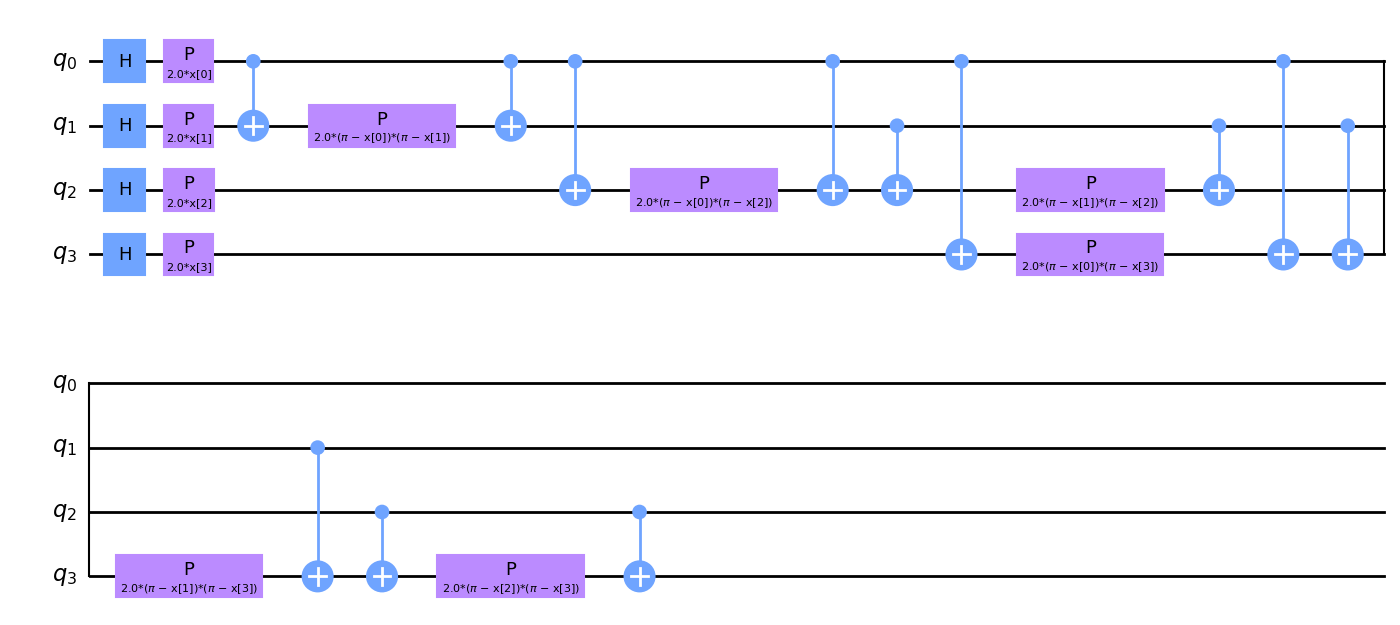

In [18]:
# we encode the 2D PCA features into quantum states using ZZ interaction
num_features = 4

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

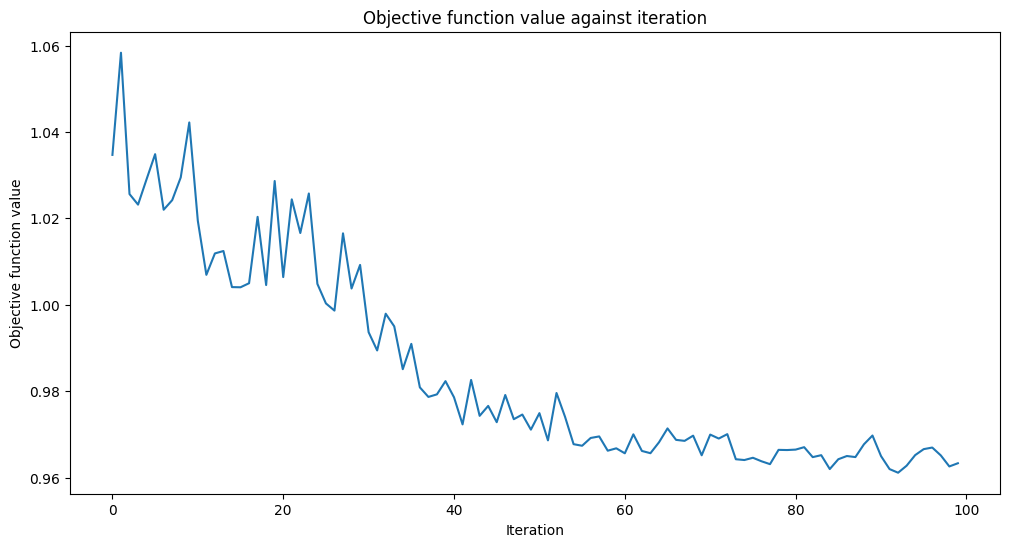

Training time: 605 seconds
Quantum VQC at N=4 on the training dataset: 0.59
Quantum VQC at N=4 on the test dataset:     0.49
N=4
              precision    recall  f1-score   support

         0.0       0.53      0.73      0.62        66
         1.0       0.40      0.22      0.29        54

    accuracy                           0.50       120
   macro avg       0.47      0.47      0.45       120
weighted avg       0.47      0.50      0.47       120




In [14]:
# train a model where there are 4 qubits
pca = PCA(n_components=4)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

ansatz = RealAmplitudes(num_qubits=4, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=4 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=4 on the test dataset:     {temp_test_score:.2f}")

print("N=4")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

### N=6

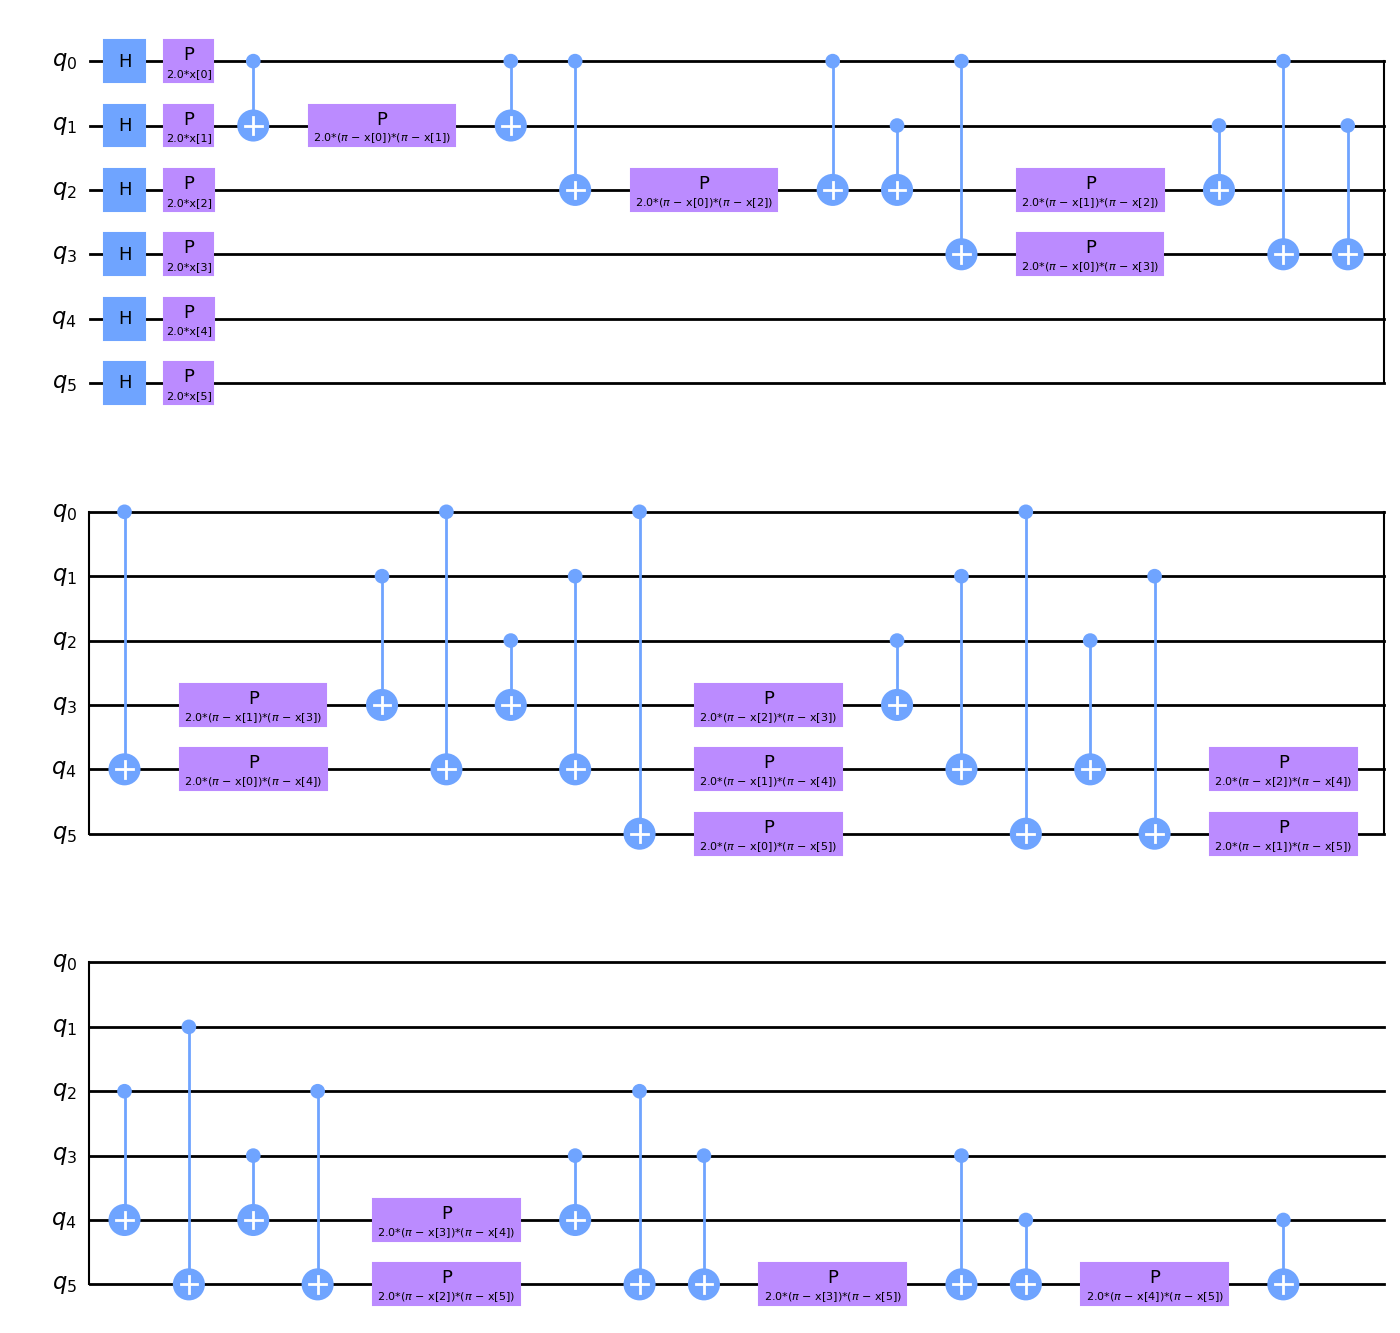

In [19]:
# we encode the 2D PCA features into quantum states using ZZ interaction
num_features = 6

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

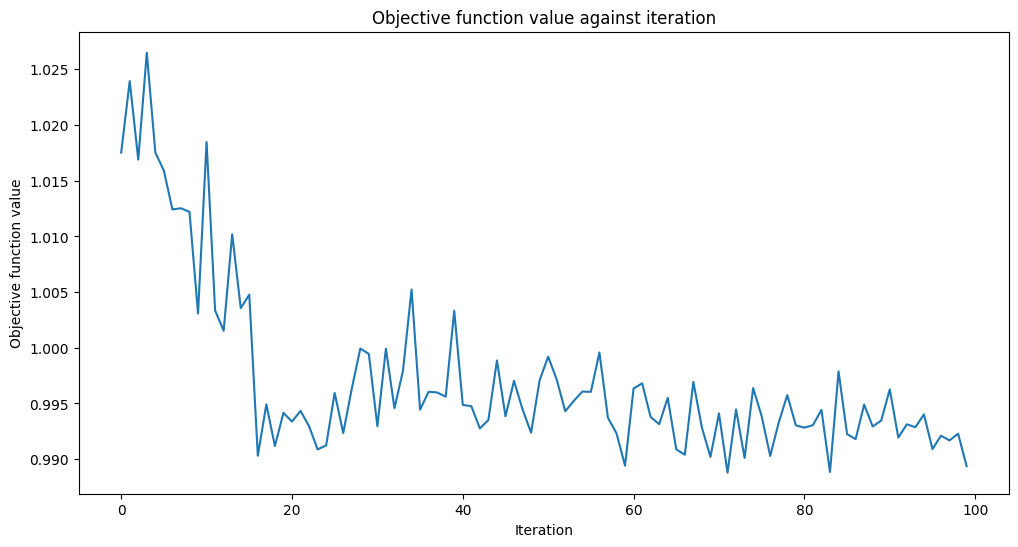

Training time: 835 seconds
Quantum VQC at N=6 on the training dataset: 0.54
Quantum VQC at N=6 on the test dataset:     0.59
N=6
              precision    recall  f1-score   support

         0.0       0.58      0.78      0.66        67
         1.0       0.50      0.28      0.36        53

    accuracy                           0.56       120
   macro avg       0.54      0.53      0.51       120
weighted avg       0.54      0.56      0.53       120




In [15]:
# train a model where there are 6 qubits
pca = PCA(n_components=6)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

feature_map = ZZFeatureMap(feature_dimension=6, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

ansatz = RealAmplitudes(num_qubits=6, reps=3)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=6 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=6 on the test dataset:     {temp_test_score:.2f}")

print("N=6")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

### Modelling Part II
Apart from using RealAmplitudes as our antasz, we'll also try EfficientSU2, another popular quantum circuit.

Everything else remains the same.

### N = 2

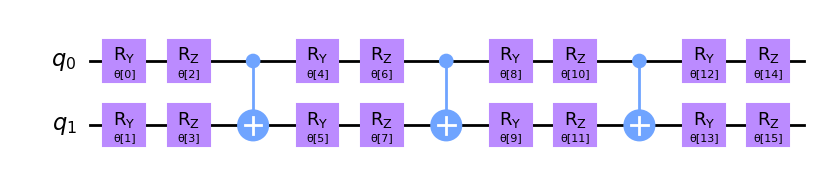

In [20]:
ansatz = EfficientSU2(num_qubits=2, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

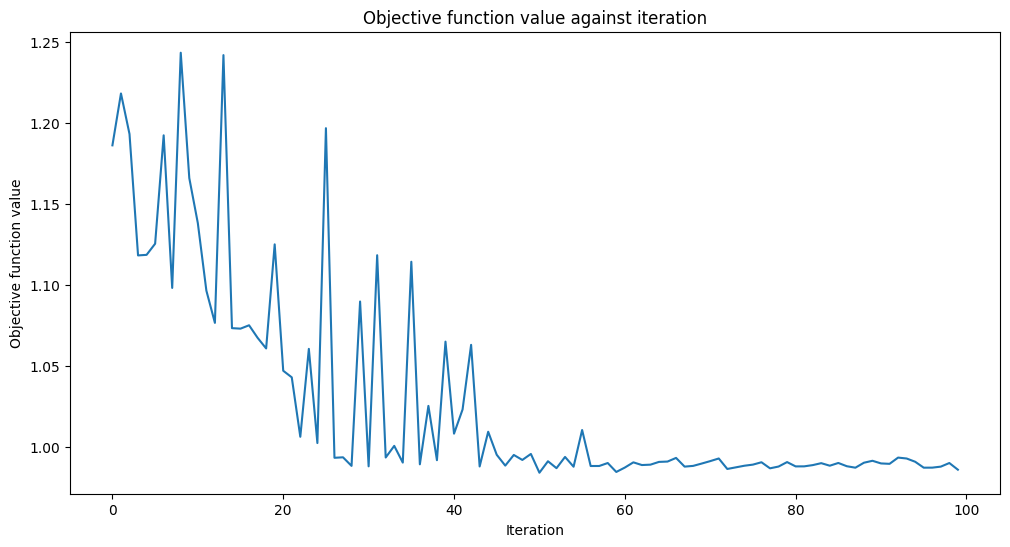

Training time: 525 seconds
Quantum VQC at N=2 on the training dataset: 0.55
Quantum VQC at N=2 on the test dataset:     0.59
N=2
              precision    recall  f1-score   support

         0.0       0.52      0.78      0.63        60
         1.0       0.57      0.28      0.38        60

    accuracy                           0.53       120
   macro avg       0.54      0.53      0.50       120
weighted avg       0.54      0.53      0.50       120




In [22]:
# train a model where there are 2 qubits using EfficientSU2
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

pca = PCA(n_components=2)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

feature_map = ZZFeatureMap(feature_dimension=2, reps=1)

ansatz = EfficientSU2(num_qubits=2, reps=3)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=2 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=2 on the test dataset:     {temp_test_score:.2f}")

print("N=2")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

### N = 4

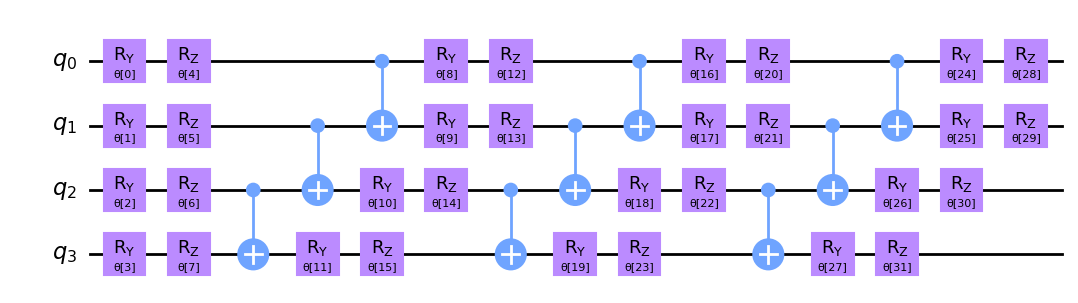

In [23]:
ansatz = EfficientSU2(num_qubits=4, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

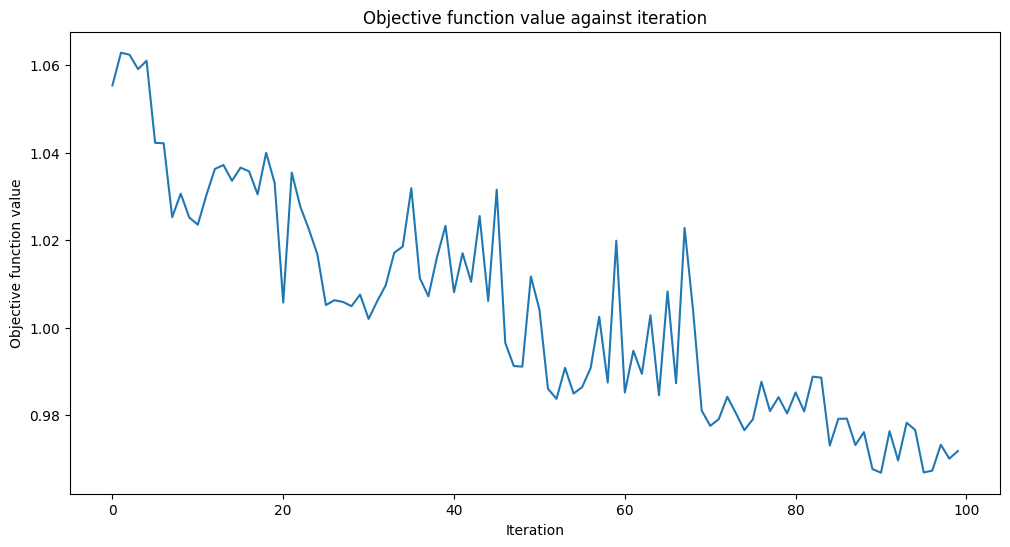

Training time: 698 seconds
Quantum VQC at N=2 on the training dataset: 0.61
Quantum VQC at N=2 on the test dataset:     0.53
N=2
              precision    recall  f1-score   support

         0.0       0.57      0.74      0.64        69
         1.0       0.40      0.24      0.30        51

    accuracy                           0.53       120
   macro avg       0.48      0.49      0.47       120
weighted avg       0.50      0.53      0.49       120




In [24]:
# train a model where there are 4 qubits using EfficientSU2
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

pca = PCA(n_components=4)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

feature_map = ZZFeatureMap(feature_dimension=4, reps=1)

ansatz = EfficientSU2(num_qubits=4, reps=3)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=2 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=2 on the test dataset:     {temp_test_score:.2f}")

print("N=4")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

N = 6

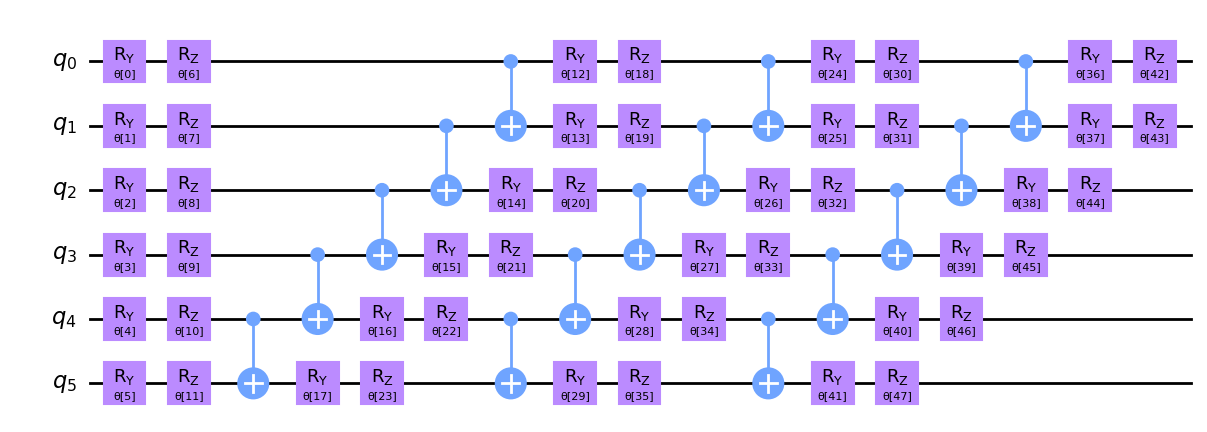

In [25]:
ansatz = EfficientSU2(num_qubits=6, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

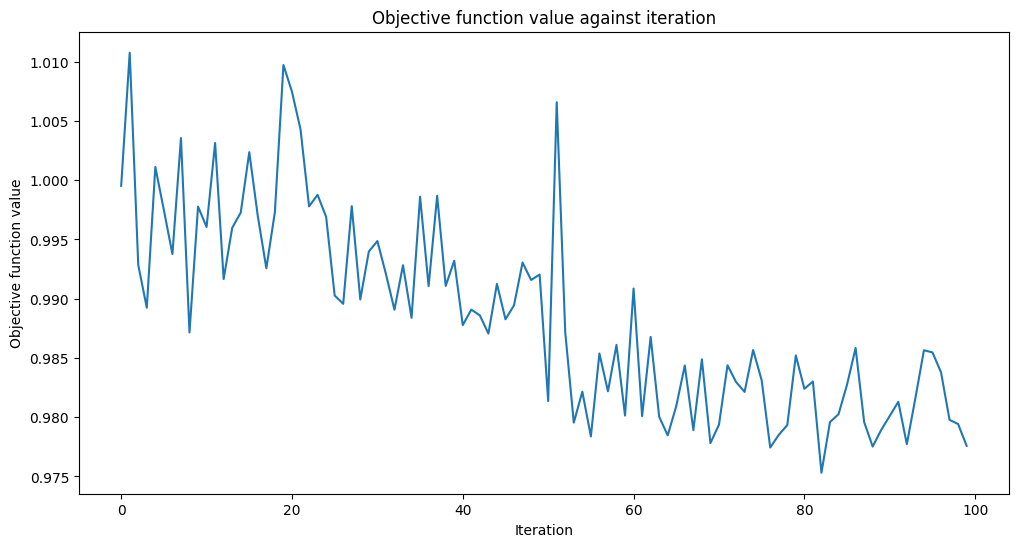

Training time: 960 seconds
Quantum VQC at N=2 on the training dataset: 0.57
Quantum VQC at N=2 on the test dataset:     0.52
N=6
              precision    recall  f1-score   support

         0.0       0.53      0.79      0.64        61
         1.0       0.57      0.29      0.38        59

    accuracy                           0.54       120
   macro avg       0.55      0.54      0.51       120
weighted avg       0.55      0.54      0.51       120




In [27]:
# train a model where there are 6 qubits using EfficientSU2
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

pca = PCA(n_components=6)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

feature_map = ZZFeatureMap(feature_dimension=6, reps=1)

ansatz = EfficientSU2(num_qubits=6, reps=3)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=2 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=2 on the test dataset:     {temp_test_score:.2f}")

print("N=6")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

# Conclusion
In this section, we explored the use of quantum machine learning techniques - specifically the Variational Quantum Classifier (VQC) - to tackle a binary classification task. Leveraging dimensionality reduction through PCA, we projected the high-dimensional molecular descriptors into subspaces of 2, 4, and 6 components, corresponding to 2, 4, and 6 qubit systems respectively.

We evaluated two popular ansätze:
- RealAmplitudes, a hardware-efficient and expressive circuit.
- EfficientSU2, a more entanglement-rich ansatz designed to capture complex correlations.

Despite careful tuning of quantum circuit depth and optimization iterations via COBYLA, model performance showed clear signs of underfitting on test data. This may be due to the inherent limitations of shallow quantum circuits, the simplicity of the feature maps, or the difficulty of the dataset after dimensionality reduction.

Key takeaways:
- Increasing the number of PCA components (qubits) did not always lead to better generalization.
- EfficientSU2 often outperformed RealAmplitudes, aligning with literature that deeper entangling circuits yield better results for complex datasets.

However, accuracy and F1 scores remained modest, suggesting that feature separability is weak or that more expressive quantum models or hybrid structures are needed.

In Part V, we will systematically investigate the model's robustness to feature-level perturbations, simulating noise or incomplete data. This will help us evaluate whether quantum models offer any advantage in resilience or generalization when inputs are degraded—an important question in real-world deployments.

